In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import date

%matplotlib inline

In [6]:
def get_annual_flights_by_airport(year=2017):
    """ Return a dataframe flight counts by day of week and year  """
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        annual_flights = pd.read_sql("""
            SELECT 
                f.origin_airport_id as airport_id,
                a.display_airport_name as airport_name,
                f.origin as origin_airport,
                f.year as year,
                SUM(f.flights) AS flights,
                SUM(f.departure_was_delayed_15) AS departure_delays,
                SUM(f.arrival_was_delayed_15) AS arrival_delays
            FROM 
                flights AS f
            JOIN
                airports as a
            ON
                f.origin_airport_id = a.airport_id
            WHERE 
                f.year = :year 
            GROUP BY 
                f.month, f.year, f.origin
        """, conn, 
        params={'year': year})
    return annual_flights

# Get summary data for selected date range, counting flights delayed more than 15 minutes on departure
annual_flights_by_airport = get_annual_flights_by_airport(2017)
annual_flights_by_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3551 entries, 0 to 3550
Data columns (total 7 columns):
airport_id          3551 non-null int64
airport_name        3551 non-null object
origin_airport      3551 non-null object
year                3551 non-null int64
flights             3551 non-null int64
departure_delays    3551 non-null int64
arrival_delays      3551 non-null int64
dtypes: int64(5), object(2)
memory usage: 194.3+ KB


In [7]:
f = annual_flights_by_airport.groupby(
        ['airport_name', 'origin_airport', 'year', 'airport_id']
    ).sum()[['flights', 'departure_delays', 'arrival_delays']]

f['fraction_delayed_on_departure'] = f['departure_delays'] / f['flights']
f['fraction_delayed_on_arrival'] = f['arrival_delays'] / f['flights']

f = f.sort_values('flights', ascending=False)
f.head(25)

,,,,flights,departure_delays,arrival_delays,fraction_delayed_on_departure,fraction_delayed_on_arrival
airport_name,origin_airport,year,airport_id,,,,,
Hartsfield-Jackson Atlanta International,ATL,2017,10397,1823275,322850,300025,0.177071,0.164553
Los Angeles International,LAX,2017,12892,1285782,298242,285324,0.231954,0.221907
Chicago O'Hare International,ORD,2017,13930,1065840,202144,217204,0.189657,0.203787
Dallas/Fort Worth International,DFW,2017,11298,724832,135516,149480,0.186962,0.206227
McCarran International,LAS,2017,12889,455160,96705,91566,0.212464,0.201173
Denver International,DEN,2017,11292,446330,80316,82752,0.179948,0.185405
Seattle/Tacoma International,SEA,2017,14747,411528,66303,72444,0.161114,0.176037
Baltimore/Washington International Thurgood Marshall,BWI,2017,10821,404060,75972,71404,0.188022,0.176716
George Bush Intercontinental/Houston,IAH,2017,12266,387813,57399,57342,0.148007,0.147860


In [8]:
total_flights = f['flights'].sum()
total_delays = f['departure_delays'].sum()
rate_of_delay = total_delays / total_flights

print("Total Domestic Departures (2017): ", "{:,}".format(total_flights))
print("Total Delayed Departures (2017):  ", "{:,}".format(total_delays))
print("Percent of Flights Delayed (2017): ", '{:5.2f}%'.format(rate_of_delay * 100))

Total Domestic Departures (2017):  17,170,622
Total Delayed Departures (2017):   3,107,430
Percent of Flights Delayed (2017):  18.10%


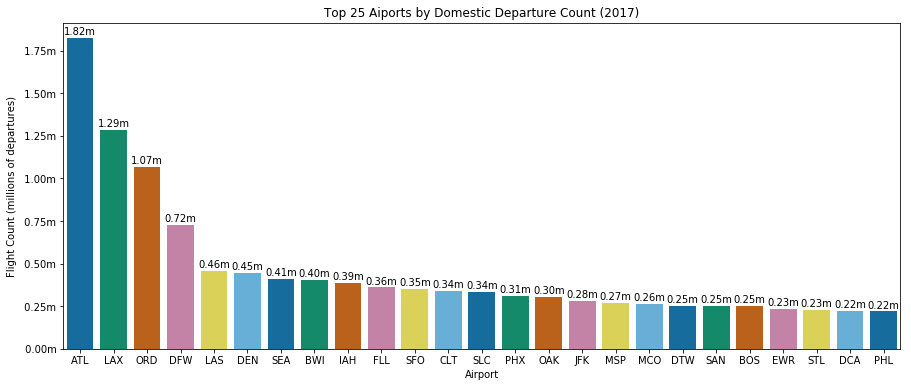

In [10]:
def plot_top_airports_flight_counts(plot_data):
    count = len(plot_data)
    ax, fig = plt.subplots(figsize=(15, 6))
    color = sns.color_palette('colorblind')
    
    ax = sns.barplot(x='origin_airport', y='flights', data=plot_data, palette=color)
    plt.title(f'Top {count} Aiports by Domestic Departure Count (2017)')
    #plt.xticks(rotation=90)
    plt.xlabel('Airport')
    plt.ylabel('Flight Count (millions of departures)')

    one_million = 1e6
    
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:5.2f}m'.format(x / one_million) for x in vals])
    
    for p in ax.patches:
        height = p.get_height()
        label_string = '{:2.2f}m'.format(height/one_million)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 0.02 * one_million,
                label_string,
                ha="center", color='black') 

    plt.savefig('../../reports/figures/busiest-airports-by-departure.png')
    plt.show()
    
plot_top_airports_flight_counts(f.head(25).reset_index())

## Which airports manage the greatest volumes of departing domestic flights?

Based on 2017 BTS data, more than 17 million domestic flights departed from 3551 airports.  The airports who saw the greatest volume of those flights include Hartsfield Atlanta International - ATL (1.82m), Los Angeles International - LAX (1.28m), Chicago O'Hare International - ORD (1.06m) and Dallas/Fort Worth International - DFW (0.72m).

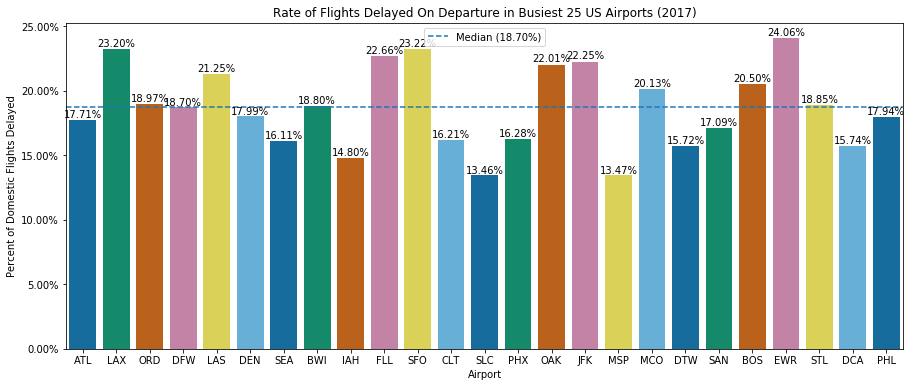

In [14]:
def plot_rates_of_delay(data):
    count = len(data)
    
    ax, fig = plt.subplots(figsize=(15, 6))
    color = sns.color_palette('colorblind')
    ax = sns.barplot(
        x='origin_airport', 
        y='fraction_delayed_on_departure', 
        data=data, 
        palette=color
    )
    plt.title(f'Rate of Flights Delayed On Departure in Busiest {count} US Airports (2017)')
    plt.xlabel('Airport')
    plt.ylabel('Percent of Domestic Flights Delayed')

    median = data['fraction_delayed_on_departure'].median()
    median_percent = '{:3.2f}%'.format(median * 100)
    hline = ax.axhline(
        y=data['fraction_delayed_on_departure'].median(), 
        xmin=0, 
        xmax=1, 
        linestyle='--', 
        label=f'Median ({median_percent})',
    )


    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
    
    for p in ax.patches:
        height = p.get_height()
        label_string = '{:3.2f}%'.format(height * 100)
        ax.text(p.get_x()+p.get_width()/2.,
                height * 1.01,
                label_string,
                ha="center", color='black') 
    
    plt.legend(handles=[hline], loc='upper center')
    plt.savefig('../../reports/figures/busiest-airports-by-rate-of-departure-delay.png')
    plt.show()

plot_rates_of_delay(f.head(25).reset_index())

## Of the largest airports, what percentage of flights were delayed in 2017?

The rate of delays appears to vary greatly even among airports of similar size.  Newark (EWR), San Francisco (SFO), and Los Angeles (LAX) were the most frequently delayed among the largest 25 airports.  Salt Lake City (SLC) and Minneapolis-St.Paul was the least frequently delayed upon departure.

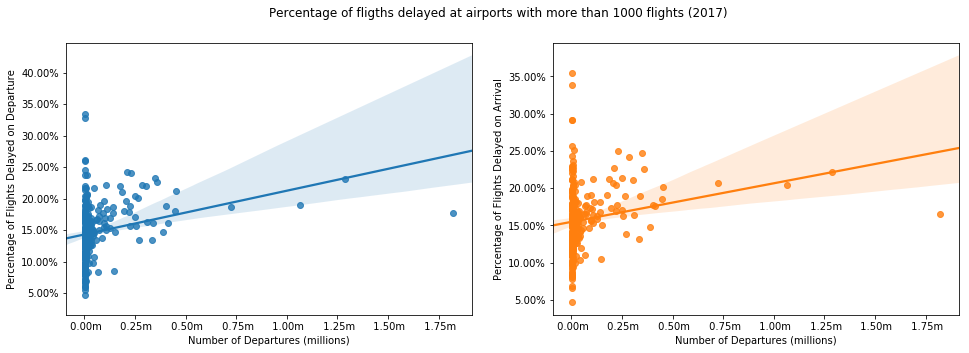

In [13]:
def plot_rates_of_delay_against_airport_size(data, minimum_flight_count=5000):
    d = data[data['flights'] > minimum_flight_count]

    a4_dims = (16, 5)
    color = sns.color_palette('colorblind')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=a4_dims)

    _ = sns.regplot(data=d, x='flights', y='fraction_delayed_on_departure', fit_reg=True, ax=ax1)
    _ = ax1.set_ylabel('Percentage of Flights Delayed on Departure')

    _ = sns.regplot(data=d, x='flights', y='fraction_delayed_on_arrival', fit_reg=True, ax=ax2)
    _ = ax2.set_ylabel('Percentage of Flights Delayed on Arrival')

    _ = plt.suptitle(f"Percentage of fligths delayed at airports with more than {minimum_flight_count} flights (2017)")

    for ax in [ax1, ax2]:
        _ = ax.set_xlabel('Number of Departures (millions)')

        vals = ax.get_yticks()
        _ = ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

        one_million = 1e6
        vals = ax.get_xticks()
        _ = ax.set_xticklabels(['{:5.2f}m'.format(x / one_million) for x in vals])
    plt.savefig('../../reports/figures/airport-size-versus-rate-of-delay.png')
    plt.show()
    
plot_rates_of_delay_against_airport_size(f, 1000)

## How does the rate of delay vary with airport size?

Plotting the rate of delay against the number of departures does not indicate a strong relationship between airport size and the rates of delay.  This suggests that other factors may be better indicators of flight delays.